## Trying out [Fake.br](https://github.com/roneysco/Fake.br-Corpus) dataset



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import nltk

In [2]:
DATA_PATH = '../Fake.br-Corpus/preprocessed/pre-processed.csv'

df = pd.read_csv(DATA_PATH, index_col = 'index')
df.head(5)

,label,preprocessed_news
index,,
0,fake,katia abreu diz vai colocar expulsao moldura n...
1,fake,ray peita bolsonaro conservador fake entrevist...
2,fake,reinaldo azevedo desmascarado policia federal ...
3,fake,relatorio assustador bndes mostra dinheiro pub...
4,fake,radialista americano fala sobre pt vendem ilus...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 0 to 7199
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              7200 non-null   object
 1   preprocessed_news  7200 non-null   object
dtypes: object(2)
memory usage: 168.8+ KB


In [4]:
df['label'].value_counts()

fake    3600
true    3600
Name: label, dtype: int64

### Transform label to bool

In [5]:
df['target'] = df['label'].map( {'fake': 0, 'true': 1} ).astype(int)

In [6]:
df.head(5)

,label,preprocessed_news,target
index,,,
0,fake,katia abreu diz vai colocar expulsao moldura n...,0
1,fake,ray peita bolsonaro conservador fake entrevist...,0
2,fake,reinaldo azevedo desmascarado policia federal ...,0
3,fake,relatorio assustador bndes mostra dinheiro pub...,0
4,fake,radialista americano fala sobre pt vendem ilus...,0


## Tokenize

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

2021-11-04 09:20:33.919587: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-04 09:20:33.919613: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
stemmer = nltk.stem.RSLPStemmer()

In [9]:
stemmed = []
for text in df['preprocessed_news'].values:
    
    tokenized = text.split()
    stem = []
    for tkn in tokenized:
        stem.append(stemmer.stem(tkn))
    stemmed.append(' '.join(stem))

In [10]:
stemmed

['kat abr diz vai coloc expulsa mold nao reclam sen kat abr diss expulsa pmdb result aca cupul atual legend segund oportun amanh vou bot mold dour expulsa porqu mao ond vei atest boa condut curricul pesso expuls nao serv pal serv pal benefici propri diss kat abr ue expulsa alg tao bom curricul tant chor kat sab motiv prova kat nao val pt part ja dev absorv parec pt gost kat soment fic entrincheir dentr pmdb rebaix demal rest kat fic chor pitang tod cant temp ate moment pt nao cadastr kat abr fil situaca pate agricult dilm',
 'ray peit bolsonar conserv fak entrev danil gentil divid direit sit vem avis jair bolsonar dev abandon paut estat vez faz discurs convinc boa part liberal conserv brasil quer ver livr amarr estatal tud bem pesquis aind diz mai part pov contr privatizaco indic pouc pov facil ser revert adem bolsonar dev fal direit vez foc tant petist arrepend recent diss pens vez ant priva petrobr nao cai mao chines alg tip dev ter dit garant privatizaca petrobr tamb garant chines n

In [11]:
df['stemmed_news'] = stemmed

In [12]:
num_words = 5000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'


tokenizer=Tokenizer(num_words = num_words, oov_token=oov_token)
tokenizer.fit_on_texts(df['stemmed_news'].values)
X = tokenizer.texts_to_sequences(df['stemmed_news'].values)

lens = np.array([len(x) for x in X])
maxlen = int(lens.mean() + lens.std() + 1)

X_pad = pad_sequences(X,padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [13]:
X_pad.shape

(7200, 746)

In [14]:
X_pad

array([[2776,  431,   16, ...,    0,    0,    0],
       [   1, 3288,  639, ...,    0,    0,    0],
       [3746, 2150,    1, ...,    0,    0,    0],
       ...,
       [2805,   29,   26, ...,  365,   10, 1817],
       [ 652,  493,  436, ...,    0,    0,    0],
       [ 182,   29,   16, ...,  376, 2086, 1708]], dtype=int32)

In [22]:
X_pad

array([[5.552e-01, 8.620e-02, 3.200e-03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.000e-04, 6.576e-01, 1.278e-01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.492e-01, 4.300e-01, 2.000e-04, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [5.610e-01, 5.800e-03, 5.200e-03, ..., 7.300e-02, 2.000e-03,
        3.634e-01],
       [1.304e-01, 9.860e-02, 8.720e-02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.640e-02, 5.800e-03, 3.200e-03, ..., 7.520e-02, 4.172e-01,
        3.416e-01]])

In [23]:
# split train-test

y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X_pad/num_words,y, test_size = 0.3, random_state = 101)
print(len(y_train[y_train == 0]))
print(len(y_train[y_train == 1]))

2526
2514


### Let's try out some models!


Mas antes alguns métodos de avaliação.

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clf_eval(clf, X, y_true, classes=['Fake', 'True']):
    y_pred = clf.predict(X)
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=classes))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred)))
    plot_confusion_matrix(clf_matrix, classes=classes)
    return roc_auc_score(y_true, y_pred)

#### Suport Vector Machine

Baseado no notebook *ML_SUP_Categorical_Classification* e nas informações disponíveis na [Motivação para SVM](https://en.wikipedia.org/wiki/Support-vector_machine#Motivation) da Wikipédia.
Tentar usar apenas o filtro linear

In [24]:
from sklearn import model_selection
from sklearn import svm
from sklearn.preprocessing import StandardScaler

Classification Report
              precision    recall  f1-score   support

        Fake       0.90      0.95      0.93      1074
        True       0.95      0.90      0.92      1086

    accuracy                           0.92      2160
   macro avg       0.93      0.92      0.92      2160
weighted avg       0.93      0.92      0.92      2160

ROC Score: 0.9242312005514574
Accuracy Score: 0.924074074074074
Average Precision Score: 0.9036408176347964
f1 Score: 0.9222748815165878
Confusion matrix, without normalization
[[1023   51]
 [ 113  973]]


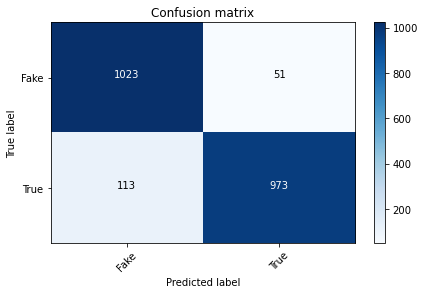

In [25]:
clf_svc = svm.SVC(kernel='linear',
                   C=0.9,  
                   shrinking=True, 
                   probability=False, 
                   tol=0.001, 
                   cache_size=200, 
                   class_weight=None, 
                   verbose=False, 
                   max_iter=-1, 
                   random_state=101)



clf_svc.fit(X_train,y_train)



roc_svc = clf_eval(clf_svc, X_test, y_test)

###  Naive Bayes



Classification Report
              precision    recall  f1-score   support

        Fake       0.88      0.98      0.93      1074
        True       0.97      0.87      0.92      1086

    accuracy                           0.92      2160
   macro avg       0.93      0.92      0.92      2160
weighted avg       0.93      0.92      0.92      2160

ROC Score: 0.9239045443789419
Accuracy Score: 0.9236111111111112
Average Precision Score: 0.913473807746102
f1 Score: 0.9197860962566845
Confusion matrix, without normalization
[[1049   25]
 [ 140  946]]


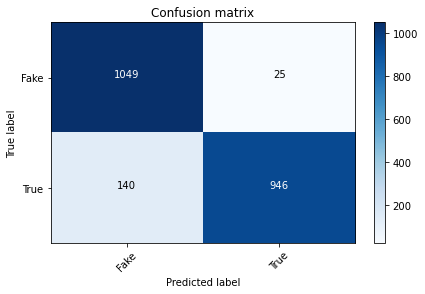

In [26]:
from sklearn import naive_bayes


clf_bayes = naive_bayes.MultinomialNB()
clf_bayes.fit(X_train,y_train)

roc_bayes = clf_eval(clf_bayes,X_test,y_test)

### Multilayer Perceptron

In [27]:
from sklearn.neural_network import MLPClassifier

Classification Report
              precision    recall  f1-score   support

        Fake       0.93      0.93      0.93      1074
        True       0.93      0.93      0.93      1086

    accuracy                           0.93      2160
   macro avg       0.93      0.93      0.93      2160
weighted avg       0.93      0.93      0.93      2160

ROC Score: 0.9277909812031236
Accuracy Score: 0.9277777777777778
Average Precision Score: 0.8986494782074893
f1 Score: 0.9279778393351802
Confusion matrix, without normalization
[[ 999   75]
 [  81 1005]]


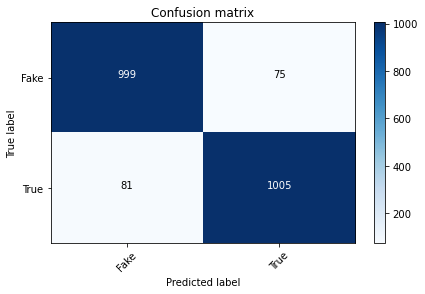

In [29]:
clf_MLP = MLPClassifier(random_state=101, max_iter=2000)
clf_MLP.fit(X_train,y_train)

roc_MLP = clf_eval(clf_MLP,X_test,y_test)